In [1]:
import numpy as np
from numpy import sin, cos, tan, exp, log, pi, sqrt, abs
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt

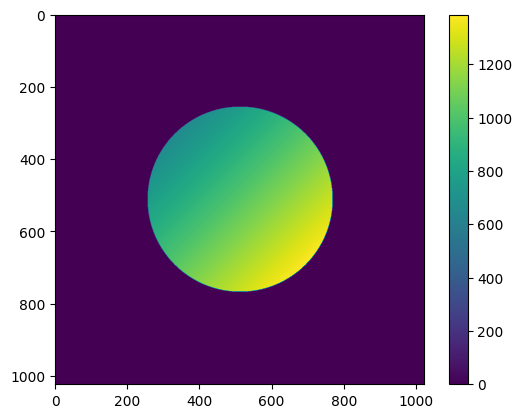

In [3]:
nPoints = 2**10 #increase from 2**10 to 2**11 to 2**12
length = 100 #length in μm on each side of the screen

#make a 2D array with nPoints in each direction
aperture = np.zeros([nPoints,nPoints])

#make x, and y value arrays
xvals = np.linspace(-0.5*length,0.5*length,nPoints,False)
yvals = np.linspace(-0.5*length,0.5*length,nPoints,False)
radius = 25 #radius of aperture
'''
for i in range(nPoints) :
    for j in range(nPoints) :
        if xvals[i]**2+yvals[j]**2 < radius**2 :
            aperture[i,j] = i+j
'''
imgplot = plt.imshow(aperture)
plt.colorbar()
plt.show()

nPoints = 2**12 #should be a power of two number of points for Fast Fourier Transforms
length = 20000 #in μm this is the total extent of our image
wavelength = 0.5 #μm
xvals = np.linspace(-0.5*length, 0.5*length, nPoints, False)
yvals = np.linspace(-0.5*length, 0.5*length, nPoints, False)

#set up the frequency-domain variables (momentum) p = hbar k
shortestSpatialPeriod = 2.*length/nPoints
highestSpatialFrequency = 2*pi/shortestSpatialPeriod
k = 2*pi/wavelength
k2 = k**2

#calculate 1D arrays for the transverse momenta: xfreq, yfreq
xfreq = np.linspace(-highestSpatialFrequency, highestSpatialFrequency, nPoints, False)
xfreq = np.fft.ifftshift(xfreq) #shifts frequencies to match output of FFT.
yfreq = np.linspace(-highestSpatialFrequency, highestSpatialFrequency, nPoints, False)
yfreq = np.fft.ifftshift(yfreq) #shifts frequencies to match output of FFT.

#component of photon momentum in the forward direction at each 2D point of the image
kz = np.zeros([nPoints,nPoints], dtype=float)

#create 2D arrays containing the kx and ky values at each point of the Fourier transform
kx, ky = np.meshgrid(xfreq, yfreq, indexing='ij') #2D grids of kx and ky values

#indexing i,j keeps x as rows and y as columns, which is not the default behavior
#create a mask for allowed regions of transverse momentum (kx**2 + ky**2 < k**2)
kr2 = kx*kx + ky*ky #transverse value of radial k squared
kmask = kr2 < k2
kr2[~kmask] = 0 #set all the points outside of the valid range to 0
kz[kmask] = sqrt(k2-kr2[kmask])

In [4]:
#set up a function that implements a lens on a given electric field "image"
def lensEfield(eField, f) :
    #eField is a complex array containing electric field values versus space (efield image)
    #f is the focal length of the lens
    return eField * exp(1j * k/(2.*f)*(xvals[xi]**2 + yvals[yi]**2) )

#define a function which will propagate an electric field "image" a distance z0 in a direction perpendicular to the image
def propEfield(eField, z0) :
    #eField is a complex 2D array for electric field "image"
    #z0 is the distance to propagate the image
    #take the Fourier transform
    resultFFT = fft2(eField)
    #make an array to hold the result after applying phase factors
    propagateFFT = np.zeros([nPoints,nPoints], dtype=complex)
    propagateFFT[kmask] = resultFFT[kmask]*exp(1j*z0*k*(k/kz[kmask]-1))#*(kz[kmask]/k)
    #calculate the inverse fft and return the complex e-field
    return ifft2(propagateFFT)
    
#define a new aperture matrix
aperture = np.zeros([nPoints,nPoints]) #zero valued 2D array
radius = 100 #μm

#make aperture to be 1 within the radius
N = range(nPoints)
xi, yi = np.meshgrid(N,N) #make 2D matrices corresponding to the x and y indices
mask = ((xvals[xi])**2 + yvals[yi]**2 < radius**2)
aperture[mask] = 1. #everywhere the mask is true becomes a 1.


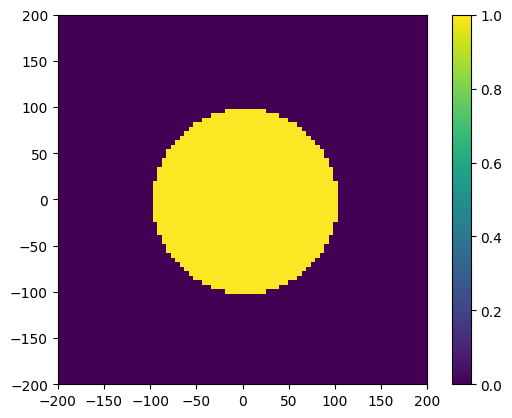

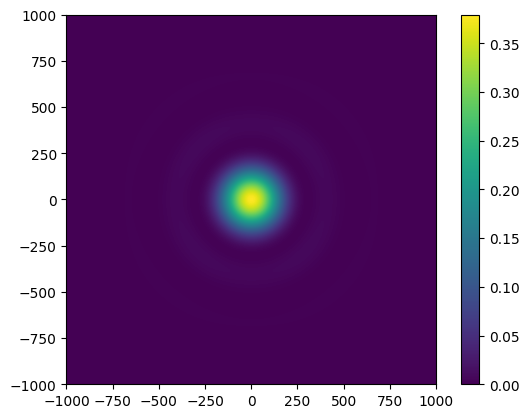

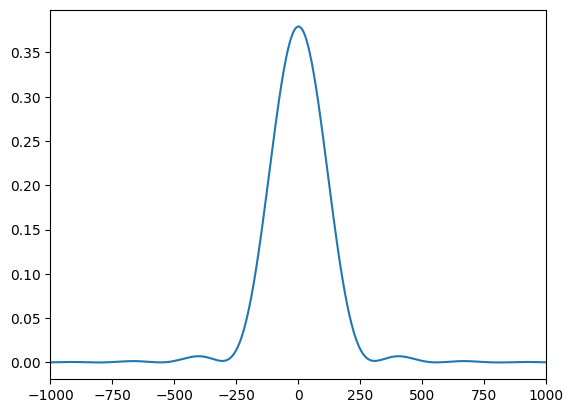

In [6]:
#show the aperture image
plt.imshow(aperture,extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length])
plt.gca().set_xlim([-200,200])
plt.gca().set_ylim([-200,200])
plt.colorbar()
plt.show()

#taking square root of irradiance gives electric field "image" to pass to function
z0 = 100000
z1 = 10000
eField = sqrt(aperture)
eField = propEfield(eField, z0) #propagate the electric field forward by z0

#eField = lensEfield(eField, z1) #applies a lens to e-field with a focal distance of z1
eFieldMid = eField

#eField = propEfield(eField, z1) #propagate the electric field forward by z1
screen = np.abs(eField)**2 #irradiance at the screen
plt.imshow(screen,extent=[-0.5*length, 0.5*length, -0.5*length, 0.5*length])
plt.gca().set_xlim([-1000,1000])
plt.gca().set_ylim([-1000,1000])
plt.colorbar()
plt.show()
lineplotx = screen[nPoints//2,:]
plt.plot(xvals, lineplotx)
plt.gca().set_xlim([-1000,1000])
plt.show()